In [1]:
# Download the dataset
!wget -nc https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/071/024/original/SteelPlant.csv

File ‘SteelPlant.csv’ already there; not retrieving.



In [2]:
import pandas as pd
df = pd.read_csv('SteelPlant.csv')

### Create target column
reverse one-hot encoding

In [3]:
df['Target'] = df.iloc[:, -7:].idxmax(axis='columns')

In [4]:
from scipy.stats import entropy
# help(entropy)

### Find entropy of target

In [5]:
p = df['Target'].value_counts(normalize=True)
entropy(p, base=2)

np.float64(2.364097425566414)

### Should we balance target ?

<Axes: xlabel='Target'>

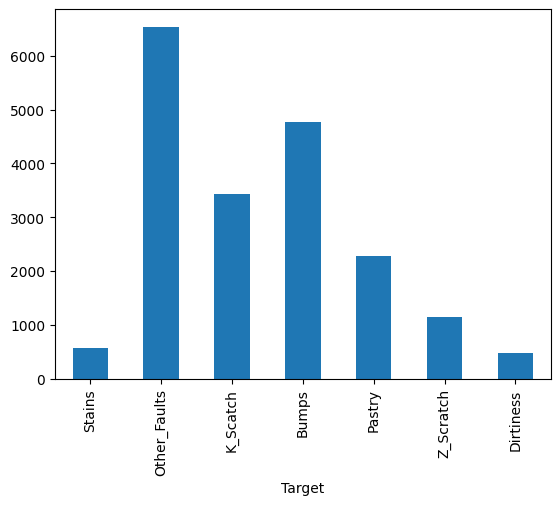

In [6]:
df['Target'].value_counts(sort=False).plot.bar()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['Pixels_Areas', 'SigmoidOfAreas']], df['Target'], test_size=0.25)

from sklearn.tree import DecisionTreeClassifier
dTreeClf = DecisionTreeClassifier(max_depth=3, random_state=42)
dTreeClf.fit(X=X_train, y=y_train)

imp = dTreeClf.tree_.impurity[0]
ftr = X_train.columns[dTreeClf.tree_.feature[0]]

ftr, round(imp, 3)

('Pixels_Areas', np.float64(0.771))

### D96 Q2. Most Misclassified DT

In [8]:
from sklearn.metrics import classification_report

X, y = df.drop(df.columns[-8:], axis='columns'), df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# typecasting for editor
X_train : pd.DataFrame = X_train
y_train : pd.Series    = y_train
X_test  : pd.DataFrame = X_test
y_test  : pd.Series    = y_test

from sklearn.tree import DecisionTreeClassifier
dTreeClf = DecisionTreeClassifier(criterion='entropy', random_state=42, class_weight="balanced")
dTreeClf.fit(X=X_train, y=y_train)

y_pred = dTreeClf.predict(X_test)

import numpy as np
report = classification_report(y_test, y_pred, target_names=np.unique(y_test))
print(report)

              precision    recall  f1-score   support

       Bumps       0.39      0.39      0.39      1165
   Dirtiness       0.14      0.18      0.16       107
    K_Scatch       0.83      0.83      0.83       852
Other_Faults       0.41      0.39      0.40      1671
      Pastry       0.22      0.21      0.22       605
      Stains       0.62      0.65      0.63       130
   Z_Scratch       0.40      0.44      0.42       275

    accuracy                           0.45      4805
   macro avg       0.43      0.44      0.44      4805
weighted avg       0.45      0.45      0.45      4805



### D96 Q3

In [9]:
depths = [3, 5, 7, 11, 13, 15, 19, 20]

from sklearn.model_selection import cross_validate, KFold
kf = KFold(n_splits=2)

for d in depths:
    model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=d)
    cv_acc_results = cross_validate(model, X_train, y_train, cv=kf, scoring='accuracy', return_train_score=True)
    print(f"depth: {d:2d} - Accuracy Mean: Train: {cv_acc_results['train_score'].mean() * 100:.2f}%, Validation: {cv_acc_results['test_score'].mean() * 100:.2f}%", end="\t")
    print(f"Accuracy Std: Train: {cv_acc_results['train_score'].std() * 100:.2f}%, Validation: {cv_acc_results['test_score'].std() * 100:.2f}%")
    # print("")

depth:  3 - Accuracy Mean: Train: 37.16%, Validation: 36.71%	Accuracy Std: Train: 4.73%, Validation: 5.33%
depth:  5 - Accuracy Mean: Train: 48.27%, Validation: 47.20%	Accuracy Std: Train: 0.32%, Validation: 0.19%
depth:  7 - Accuracy Mean: Train: 48.35%, Validation: 45.15%	Accuracy Std: Train: 2.31%, Validation: 2.33%
depth: 11 - Accuracy Mean: Train: 61.34%, Validation: 46.96%	Accuracy Std: Train: 0.35%, Validation: 0.16%
depth: 13 - Accuracy Mean: Train: 70.04%, Validation: 47.45%	Accuracy Std: Train: 0.08%, Validation: 0.10%
depth: 15 - Accuracy Mean: Train: 79.43%, Validation: 47.69%	Accuracy Std: Train: 0.88%, Validation: 0.29%
depth: 19 - Accuracy Mean: Train: 91.95%, Validation: 47.22%	Accuracy Std: Train: 2.05%, Validation: 0.57%
depth: 20 - Accuracy Mean: Train: 93.44%, Validation: 47.70%	Accuracy Std: Train: 2.13%, Validation: 0.56%


Note: depth=5 has is best -- training accuracy is approx equal to testing accuracy

In [10]:
d = 5
model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=d)

model.fit(X_train, y_train)

pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).iloc[:3]

Outside_X_Index       0.319797
Pixels_Areas          0.294860
Length_of_Conveyer    0.125352
dtype: float64

In [11]:
from imblearn.over_sampling import SMOTE
smote_obj = SMOTE(random_state=42)

X_sm, y_sm = smote_obj.fit_resample(X, y)

pd.DataFrame.from_dict(
    {
        'y': y.value_counts().to_dict(),
        'y_sm' : y_sm.value_counts().to_dict()
    }
)

,y,y_sm
Other_Faults,6540,6540
Bumps,4761,6540
K_Scatch,3431,6540
Pastry,2284,6540
Z_Scratch,1150,6540
Stains,568,6540
Dirtiness,485,6540


In [12]:
from sklearn.ensemble import RandomForestClassifier

def runRFC(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rf_clf = RandomForestClassifier(oob_score=True, random_state=42)
    rf_clf.fit(X_train, y_train)
    return rf_clf.score(X_test, y_test)

print(f'Original : {runRFC(X, y)}')
print(f'Balanced : {runRFC(X_sm, y_sm)}')

Original : 0.5560874089490114
Balanced : 0.781826124945391


In [13]:
rf_clf = RandomForestClassifier(oob_score=True, random_state=42)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42)
rf_clf.fit(X_train_sm, y_train_sm)
y_pred_sm = rf_clf.predict(X_test_sm)

from sklearn.metrics import classification_report

import numpy as np
report = classification_report(y_test_sm, y_pred_sm, target_names=np.unique(y_test_sm), output_dict=True)
pd.DataFrame(report).loc['recall', :].sort_values(ascending=False)

Stains          0.996889
K_Scatch        0.947748
Dirtiness       0.947236
Z_Scratch       0.928010
macro avg       0.782582
accuracy        0.781826
weighted avg    0.781826
Pastry          0.637664
Bumps           0.594662
Other_Faults    0.425869
Name: recall, dtype: float64

In [14]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, param_distributions=params, n_iter=30, cv=2, verbose=1, random_state=42)

rs.fit(X_train_sm, y_train_sm)

print('Best params: {}\nBest Score: {}'.format(rs.best_params_, rs.best_score_))

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best Score: 0.7515072421073159


<Axes: >

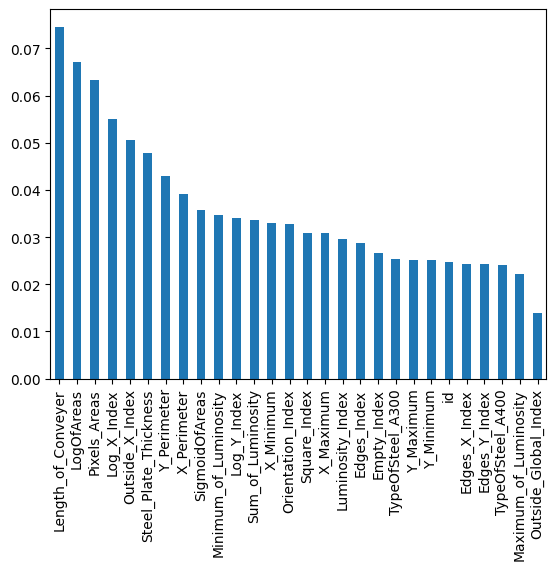

In [18]:
pd.Series(rs.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).plot.bar()